In [7]:

import math, random
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import rca_py


In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


Using cpu device


In [10]:
action_num = 3

In [11]:
def plot(frame_idx, rewards, losses,epsilon):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. threshold: %.2f dB. e: %.2f' % (frame_idx, 5-np.mean(rewards[-10:]), epsilon))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

# Define Neural Network

In [12]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()        
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(num_inputs,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500,num_actions)
        )
    
    def forward(self,x):
        x=self.flatten(x)
        logits = self.layers(x)
        return logits
    
    def act(self, state, epsilon):
        if(random.random()>epsilon):
            state = Variable(torch.FloatTensor(state).unsqueeze(0))
            state = state/4.0
            q_value = self.forward(state)       
            action = q_value.max(1)[1].data[0]     
        else:
            # use other choice 
            action = np.random.choice(action_num,1, p=[0.60,0.20,0.20])[0]
        return action

## test DQN

In [13]:
'''
test_matrix = np.loadtxt("test_matrix.txt")
test_input_size = test_matrix.size
x_np = torch.from_numpy(test_matrix)
x_np = torch.unsqueeze(x_np,0)
test_model=DQN(test_input_size,action_num)
#action = test_model.act(x_np.float(),0)
action = test_model.act(test_matrix,0)
'''



'\ntest_matrix = np.loadtxt("test_matrix.txt")\ntest_input_size = test_matrix.size\nx_np = torch.from_numpy(test_matrix)\nx_np = torch.unsqueeze(x_np,0)\ntest_model=DQN(test_input_size,action_num)\n#action = test_model.act(x_np.float(),0)\naction = test_model.act(test_matrix,0)\n'

## Define the synchronization function 

In [14]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

## define two neural networks

In [15]:
current_model = DQN(55,action_num)
target_model = DQN(55,action_num)
if USE_CUDA:
    current_model = current_model.cuda()
    target_model = target_model.cuda()
update_target(current_model,target_model)
optimizer = optim.Adam(current_model.parameters(), lr=0.00001)


# Define Replay Buffer

In [16]:
class NaviePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha= 0.6):
        self.prob_alpha = prob_alpha
        self.capacity = capacity
        self.buffer = [] 
        self.pos = 0 
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state = np.expand_dims(state,0)
        next_state = np.expand_dims(next_state,0) #?
        max_prio = self.priorities.max() if self.buffer else 1.0 #if buffer is empty then set the priority as 1.0
        if len(self.buffer)<self.capacity:
            # the buffer is not full -> just append 
            self.buffer.append((state,action,reward,next_state,done))
        else:
            # otherwise, I will delete the "oldest" one
            # --> why don't we delete the one with lowest priorites ?
            self.buffer[self.pos] = (state,action,reward,next_state,done)       
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos+1)%self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = prios ** self.prob_alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer),batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total*probs[indices])**(-beta) #eq. in sec.3.4
        weights /= weights.max()
        weights = np.array(weights,dtype= np.float32)

        batch = list(zip(*samples))
        states = np.concatenate(batch[0])
        actions = batch[1]
        #print(action)
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]
        return states, actions, rewards, next_states, dones, indices, weights 
    
    def update_priorities(self,batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices,batch_priorities):
            self.priorities[idx]=prio

    def __len__(self):
        return len(self.buffer)

## initialzie replay buffer

In [17]:
replay_buffer=NaviePrioritizedBuffer(100000)

# Compute TD Error

In [18]:
def computed_td_loss(batch_size,beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size,beta)

    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))
    weights = Variable(torch.FloatTensor(weights))

    q_values = current_model(state) #Q(S_{j-1}, *)
    q_values_predict = current_model(next_state) #Q(S_{j},*)
    next_q_values = target_model(next_state) #Q_{tar}(S_j)

    q_value = q_values.gather(1,action.unsqueeze(1)).squeeze(1) #Q(S_{j-1},A_{j-1})
    next_q_value = next_q_values.gather(1,q_values_predict.max(1)[1].unsqueeze(1)).squeeze(1) #Q_{tar}(S_j, max Q(S_j,*))
    #next_q_value = next_q_values.gather(1,q_values.max(1)[1].unsqueeze(1)).squeeze(1) # equation is equal to paper *this get wrong ...
    expected_q_value = reward+gamma*next_q_value*(1-done)
    loss = (q_value-expected_q_value.detach()).pow(2)*weights
    prios = abs(q_value-expected_q_value.detach())# priority defined as the original paper 
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices,prios.data.cpu().numpy())
    optimizer.step()

    return loss

    


# Class pbrl_env

In [19]:
class pbrl_env(object):
    def __init__(self):
        self.cur_state = np.loadtxt("init_small.txt",dtype=np.int16)
        self.total_row = self.cur_state.shape[0]
        self.total_col = self.cur_state.shape[1]
        self.sub_row = self.total_row-2
        self.sub_col = self.total_col-4
        self.this_rca=rca_py.rca_py(self.cur_state)
        self.count = 0
    
    def reset(self):
        self.cur_state = np.loadtxt("init_small.txt",dtype=np.int16)
        self.count = 0
        return self.cur_state
    
    def step(self,action):
        assert self.count < self.sub_row*self.sub_col
        row_ind = self.count//self.sub_col
        col_ind = self.count%self.sub_col
        self.cur_state[row_ind+2][col_ind+1] = action
        

        if self.count == self.sub_row*self.sub_col-1: 
            self.this_rca.patiry_check_matrix = self.cur_state
            self.this_rca.parser()
            reward = 5 - self.this_rca.get_thrshold(-5,5,0.01)
            done = 1
            self.count = 0
        else: 
            reward = 0
            done = 0
            self.count=self.count+1
        
        return self.cur_state,reward,done


## test pbrl_env

In [20]:

this_pbrl_env=pbrl_env()
print(this_pbrl_env.sub_col,this_pbrl_env.sub_row)
done = False

for ii in range(120):
    if done:
        this_pbrl_env.reset()
    cur_state,reward, done=this_pbrl_env.step(np.random.choice(action_num,1, p=[0.60,0.20,0.20])[0])
    print(cur_state)
    #sys.stdout.write("check: time: {} || count: {} || done: {} || reward: {}\n".format(ii,this_pbrl_env.count, done, reward))




OSError: init_small.txt not found.

# Define $\epsilon$ (greedy rate) and $\beta$

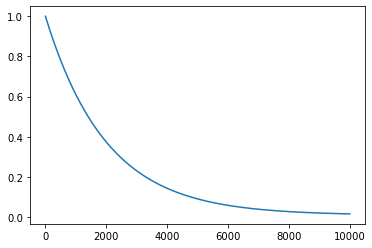

In [ ]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)


epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 2000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
plt.plot([epsilon_by_frame(i) for i in range(10000)])

# Trainig

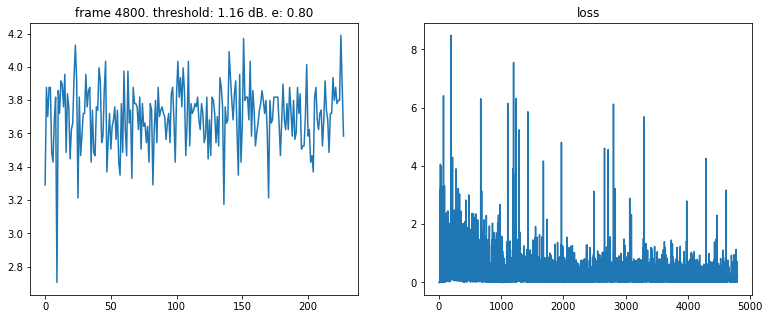

KeyboardInterrupt: 

In [ ]:
num_frames = 1000000
batch_size = 5
gamma = 0.99
this_pbrl_env=pbrl_env()
losses = [] 
all_rewards = []
episod_reward = 0

state = this_pbrl_env.reset()
for frame_idx in range(1,num_frames+1):
    epsilon=epsilon_by_frame(frame_idx)
    epsilon = 0.80
    
    action = current_model.act(state,epsilon)

    next_state, reward, done = this_pbrl_env.step(action)
    replay_buffer.push(state,action,reward,next_state,done)

    state = next_state
    episod_reward += reward

    if done:
        if frame_idx % 200 == 0:
            np.savetxt("result.txt",state, fmt="%d")
        state = this_pbrl_env.reset()
        all_rewards.append(episod_reward)
        episod_reward = 0
    
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = computed_td_loss(batch_size,beta)
        losses.append(loss.data)
    
    if frame_idx % 200 == 0: 
        plot(frame_idx, all_rewards, losses,epsilon)
    
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)